## Exercício Computacional 02

## Utilizando Algoritmos Não Supervisionados para categorização em problemas de classificação

#### Você pode usar o aprendizado não supervisionado para cenários em que os dados não estejam rotulados e o objetivo seja descobrir padrões, agrupar instâncias semelhantes ou detectar anomalias. Também é possível usá-lo para tarefas exploratórias em que os dados rotulados estejam ausentes.



In [18]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
magic_gamma_telescope = fetch_ucirepo(id=159)

# data (as pandas dataframes)
X = magic_gamma_telescope.data.features
y = magic_gamma_telescope.data.targets

# metadata
print(magic_gamma_telescope.metadata)

# variable information
print(magic_gamma_telescope.variables)

target = y['class'][:]
T = []
for i in y['class']:
  if i == 'g':
    T.append(1)
  else:
    T.append(0)

data = X.values.tolist()
inputData = np.array(list(k for k in data))
targetData = T

{'uci_id': 159, 'name': 'MAGIC Gamma Telescope', 'repository_url': 'https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope', 'data_url': 'https://archive.ics.uci.edu/static/public/159/data.csv', 'abstract': 'Data are MC generated to simulate registration of high energy gamma particles in an atmospheric Cherenkov telescope', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 19020, 'num_features': 10, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2004, 'last_updated': 'Tue Dec 19 2023', 'dataset_doi': '10.24432/C52C8B', 'creators': ['R. Bock'], 'intro_paper': None, 'additional_info': {'summary': "The data are MC generated (see below) to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamm

In [4]:
np.shape(inputData)

(19020, 10)

### Utilizando o algoritmo k-means para Clusterização.

#### Investigando o melhor número de clusters para serem utilizados.

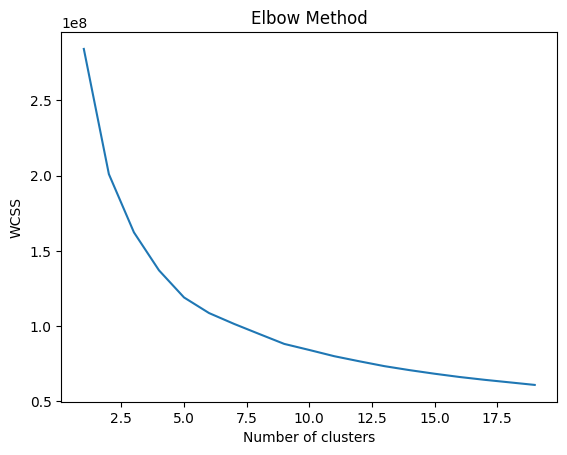

In [5]:
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=400, n_init=20, random_state=0)
    kmeans.fit(inputData)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [6]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=5000, n_init=10, random_state=0)
kmeans.fit(inputData)
k_class = kmeans.predict(inputData)

#### Comparando o alvos definindos pelo k-means com os alvos pré-definidos:

In [9]:
PDF = pd.DataFrame(data = targetData, columns = ['Cluster'])
PDF.loc[:, 'Cluster'] = pd.Series(k_class)
PDF.loc[:, 'Cluster_truth'] = pd.Series(targetData)

In [10]:
PDF['Cluster'].value_counts()

,count
Cluster,
0,15181
1,3839


In [11]:
PDF['Cluster_truth'].value_counts()

,count
Cluster_truth,
1,12332
0,6688


#### Treinando classificadores usando o alvo definido pelo k-means

In [12]:
xTrain, xTest, yTrain, yTest = train_test_split(inputData, k_class, test_size = 0.25, random_state = 0)

### Algoritmo kNN

Text(0.5, 1.0, 'k v/s Accuracy for KNN')

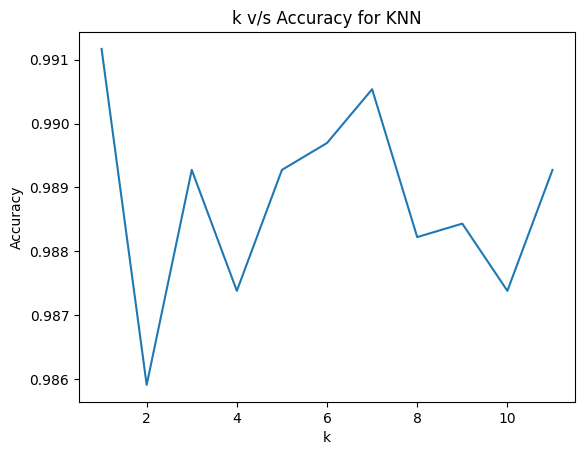

In [13]:
# KNN for various values of k and plot of k v/s accuracy
from sklearn.neighbors import KNeighborsClassifier
accuracy = []
for i in range(1,12):
    knn = KNeighborsClassifier(n_neighbors = i).fit(xTrain, yTrain)
    accuracy.append(knn.score(xTest, yTest))

plt.plot(range(1,12), accuracy)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('k v/s Accuracy for KNN')

In [14]:
knn = KNeighborsClassifier(n_neighbors = accuracy.index(max(accuracy))+1).fit(xTrain, yTrain)
knn_predictions = knn.predict(xTest)
knn_accuracy = knn.score(xTest, yTest)
knn_accuracy

0.9911671924290221

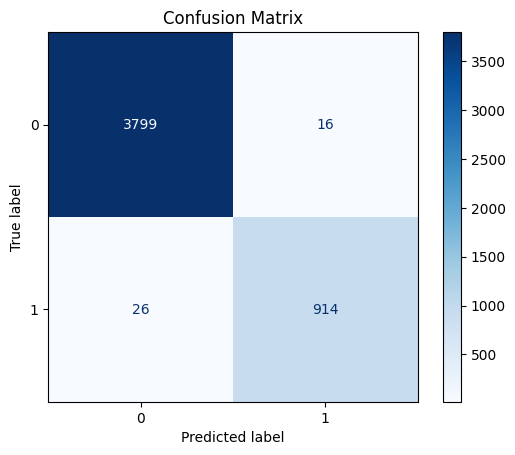

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
knn_CM = confusion_matrix(yTest, knn_predictions) # KNN Confusion Matrix

disp = ConfusionMatrixDisplay(confusion_matrix=knn_CM)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


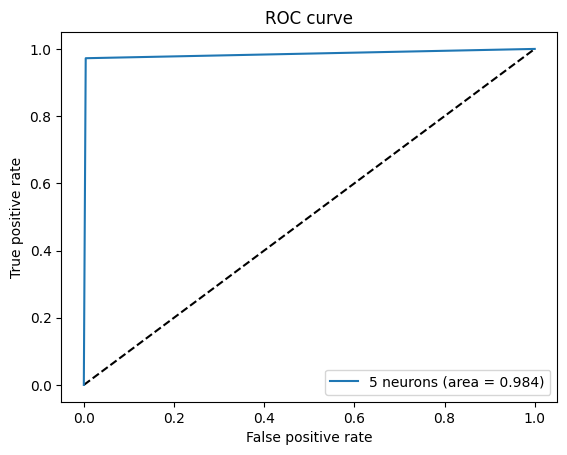

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

# model knn
y_pred_knn = knn.predict(xTest).ravel()
fpr_knn, tpr_knn, thresholds_knn = roc_curve(yTest, y_pred_knn)
auc_knn = auc(fpr_knn, tpr_knn)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_knn, tpr_knn, label='5 neurons (area = {:.3f})'.format(auc_knn))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

plt.show()

### Redes Neurais MLP

In [19]:
model = Sequential()
model.add(Dense(5, activation='relu', input_dim=10))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

hist = model.fit(xTrain, yTrain, validation_data=(xTest, yTest), epochs=50, batch_size=100)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 5)                   │              55 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61 (244.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3650 - loss: 16.1000 - val_accuracy: 0.8570 - val_loss: 0.9635
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8746 - loss: 0.8082 - val_accuracy: 0.8810 - val_loss: 0.7201
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8850 - loss: 0.6742 - val_accuracy: 0.8843 - val_loss: 0.5914
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8909 - loss: 0.5251 - val_accuracy: 0.8917 - val_loss: 0.4917
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8987 - loss: 0.4516 - val_accuracy: 0.8959 - val_loss: 0.4177
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9023 - loss: 0.3873 - val_accuracy: 0.9030 - val_loss: 0.3515
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9131 - loss: 0.3272 - val_accuracy: 0.9140 - val_loss: 0.3041
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9175 - loss: 0.2803 - val_accuracy: 0

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


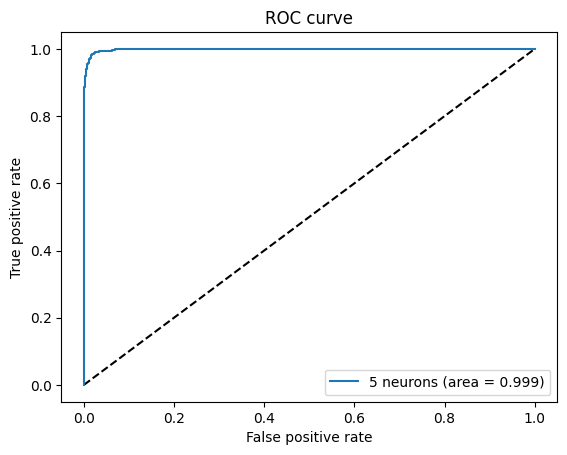

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

x_test = xTest
y_test = yTest

# model 1
y_pred_keras = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='5 neurons (area = {:.3f})'.format(auc_keras))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

plt.show()

### Avaliando a Análise de Componentes Principais

<ipython-input-23-424f723d785f>:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(a1, a2, c = c1, alpha=0.3, cmap='viridis')


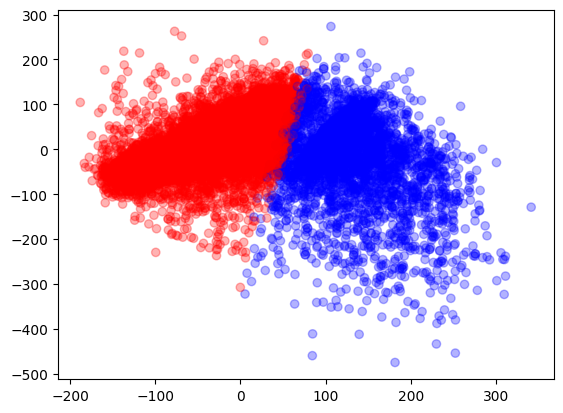

In [23]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(inputData)
PDFpca = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
PDFpca.loc[:, 'Cluster'] = pd.Series(k_class)
PDFpca['Color'] = PDFpca['Cluster'].map({0 : 'red', 1 : 'blue', 2 : 'green'})

a1 = PDFpca['PC1']
a2 = PDFpca['PC2']
c1 = PDFpca['Color']
plt.scatter(a1, a2, c = c1, alpha=0.3, cmap='viridis')

In [24]:
principalComponents

array([[-117.84756134,  -14.90843517],
       [ -10.03020362,   39.38496448],
       [  58.82204263,   40.77377882],
       ...,
       [  63.16087604,   34.64817335],
       [ 211.45336229,   17.46252333],
       [ 187.96313576, -204.38635587]])

### Utilizando os Componentes Principais como entrada do k-means:

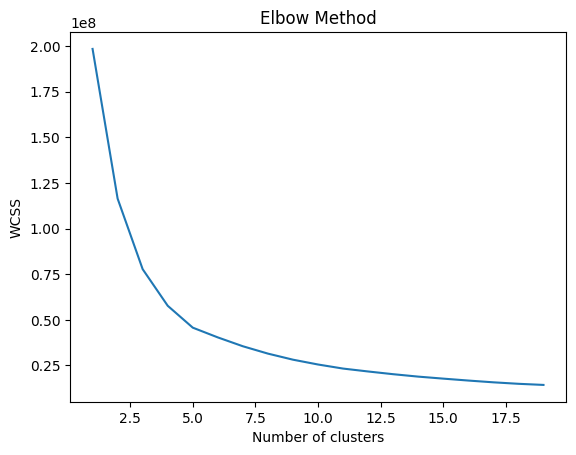

In [25]:
wcss = []
for i in range(1, 20):
    kmeans_pca = KMeans(n_clusters=i, init='k-means++', max_iter=400, n_init=20, random_state=0)
    kmeans_pca.fit(principalComponents)
    wcss.append(kmeans_pca.inertia_)

plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [26]:
kmeans_pca = KMeans(n_clusters=2, init='k-means++', max_iter=1000, n_init=10, random_state=0)
kmeans_pca.fit(principalComponents)
k_class_pca = kmeans_pca.predict(principalComponents)

In [27]:
PDF.loc[:, 'Cluster_pca'] = pd.Series(k_class_pca)
PDF['Cluster_pca'].value_counts()

,count
Cluster_pca,
0,15120
1,3900
